<a href="https://colab.research.google.com/github/nike-2001/Toxicity-Detection/blob/main/toxic_comment_classification_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install transformers library
!pip install transformers datasets

# Import necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, f1_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
nlp = spacy.load('en_core_web_lg')

In [7]:
!unzip -n ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
!unzip -n ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
!unzip -n ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
!unzip -n ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip

unzip:  cannot find or open ../train.csv.zip, ../train.csv.zip.zip or ../train.csv.zip.ZIP.
unzip:  cannot find or open ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip, ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip.zip or ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip.ZIP.
unzip:  cannot find or open ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip, ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip.zip or ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip.ZIP.
unzip:  cannot find or open ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip, ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip.zip or ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip.ZIP.


In [6]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')

In [7]:
target_columns = list(sample.columns.drop('id'))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
sample

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [9]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
# The low mean indicates that only few comments are actually labelled:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# The counts show an imbalanced dataset, both between labels but also with no label at all:
train[target_columns].sum()

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


In [12]:
# Let's add some more labels for the purpose of the analysis
train['non-toxic'] = 1-train[target_columns].max(axis=1)

train['toxicity_type_defined'] = train[['insult','obscene','identity_hate','threat']].max(axis=1)

train['toxic_undefined'] = 0
train.loc[(train['toxicity_type_defined']==0)&(train['toxic']==1),'toxic_undefined'] = 1

train['soft_toxic'] = 0
train.loc[(train['toxicity_type_defined']==1)&(train['toxic']==0),'soft_toxic'] = 1

analysis_columns = target_columns + ['non-toxic', 'toxic_undefined', 'soft_toxic']

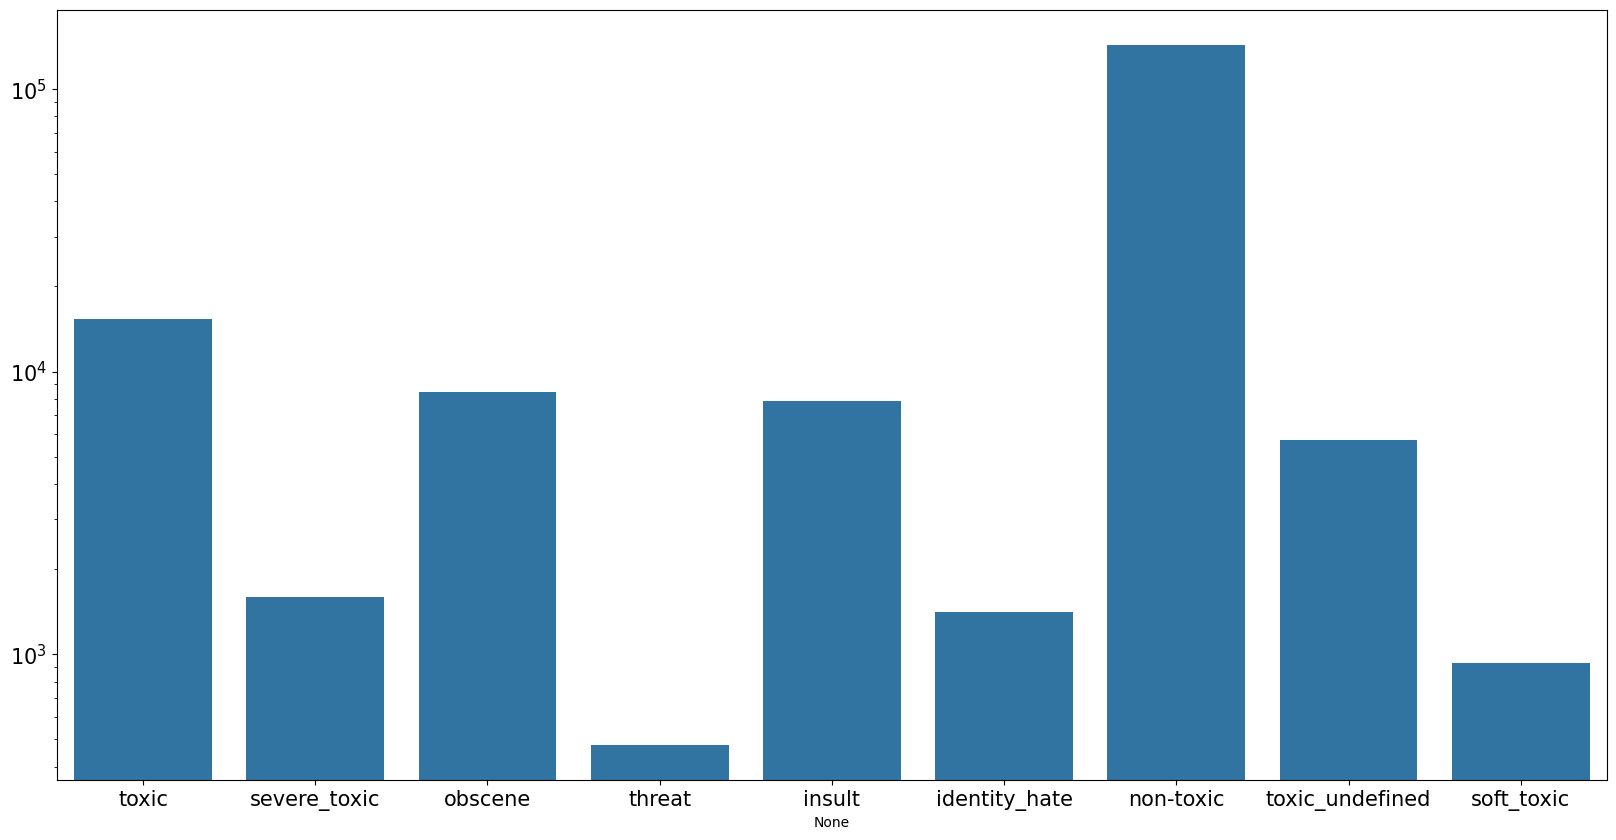

In [13]:
label_counts = train[analysis_columns].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

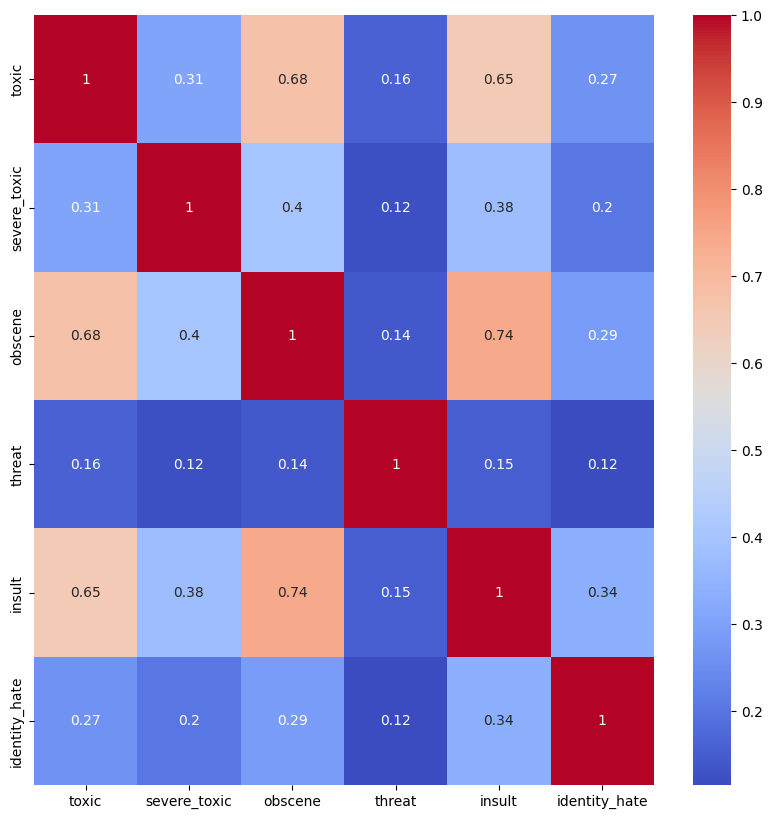

In [14]:
# Visualise any correlations between labels:
# It seems there are some strong correlations between labels
heatmap_data = train[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='coolwarm', annot=True)
ax.tick_params(labelsize=10)

In [15]:
# Confirm that all severly toxic comments (n=1595) are toxic:
train.loc[train['severe_toxic']==1,'toxic'].sum()

1595

In [16]:
print(type(train))
print(train.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'non-toxic', 'toxicity_type_defined',
       'toxic_undefined', 'soft_toxic'],
      dtype='object')


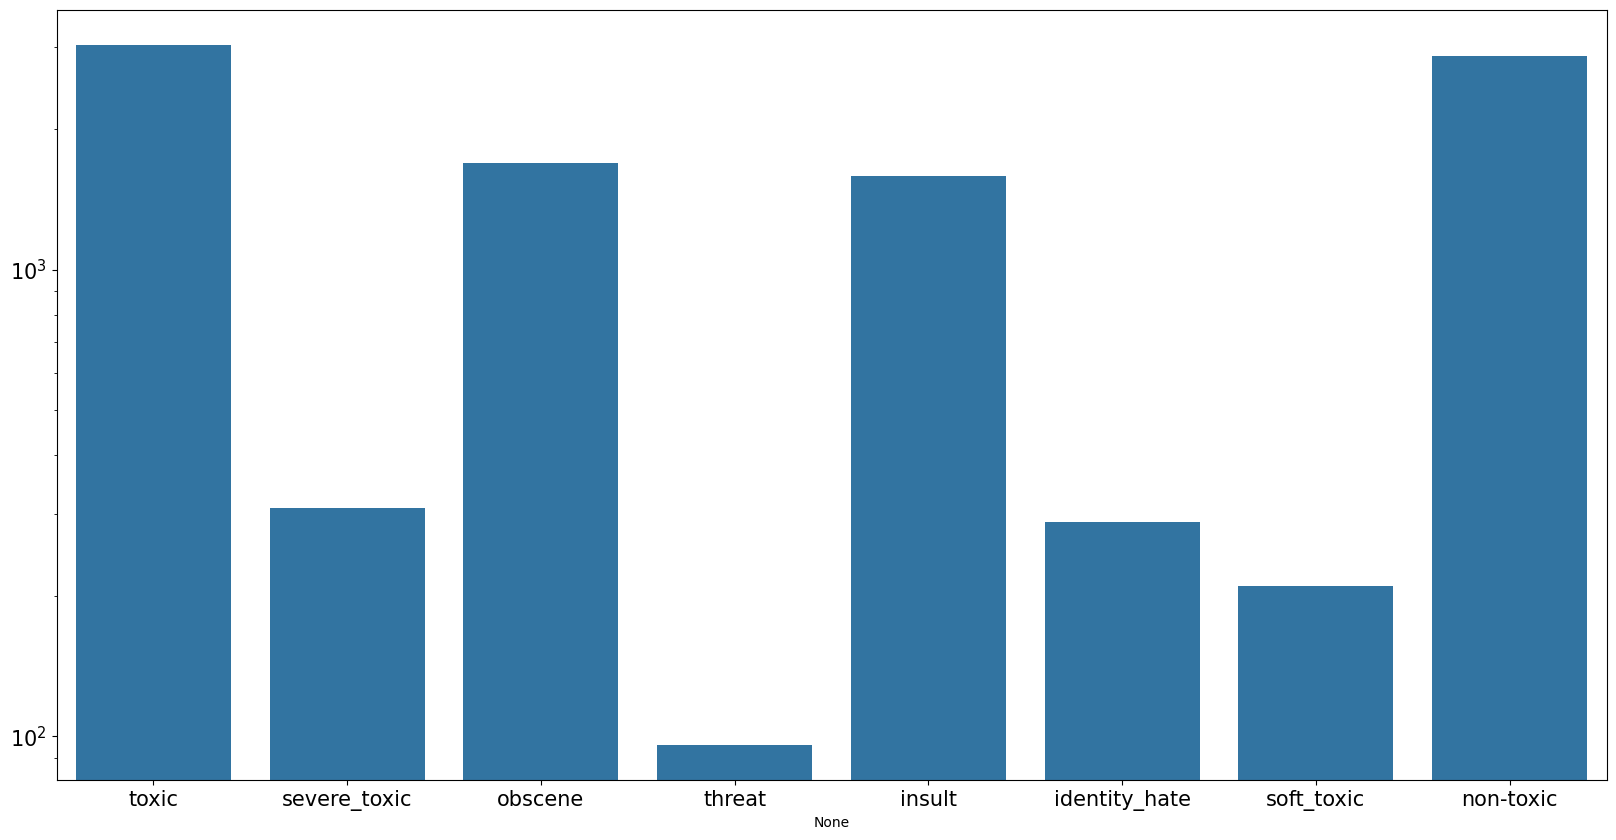

In [20]:
import pandas as pd

# Define train_balanced
#train_balanced = pd.concat([train[train['non-toxic'] == 1].sample(frac=0.11), train.loc[train['non-toxic'] == 0]])
train_balanced = pd.concat([train[train['non-toxic'] == 1].sample(frac=0.02), train.loc[train['non-toxic'] == 0].sample(frac=0.2)])

# Shuffle the DataFrame
train_balanced = train_balanced.sample(frac=1)

# Define target_columns
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'soft_toxic']

# Now you can proceed with using train_balanced and target_columns
label_counts = train_balanced[target_columns + ['non-toxic']].sum()
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values)
ax.set_yscale("log")
ax.tick_params(labelsize=15)

In [21]:
all_tokens = []
lemmas = []
nonstop_tokens = []
total_number_of_tokens = []
number_of_sentences = []
number_of_puncts = []
glove_vector = []

for doc in nlp.pipe(train_balanced['comment_text'].astype('unicode').values, batch_size=50):
    if doc.has_annotation("DEP"):
        all_tokens.append([t.lower_ for t in doc])
        nonstop_tokens.append([t.lower_ for t in doc if t.is_alpha and not t.is_stop])
        lemmas.append([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])
        total_number_of_tokens.append(doc.__len__())
        number_of_sentences.append(sum(1 for _ in doc.sents))
        number_of_puncts.append(sum(1 for t in doc if t.is_punct))
        glove_vector.append(doc.vector.tolist())
    else:
        all_tokens.append(None)
        nonstop_tokens.append(None)
        lemmas.append(None)
        total_number_of_tokens.append(None)
        number_of_sentences.append(None)
        number_of_puncts.append(None)
        glove_vector.append(None)

train_balanced['all_tokens'] = all_tokens
train_balanced['nonstop_tokens'] = nonstop_tokens
train_balanced['lemmas'] = lemmas
train_balanced['total_number_of_tokens'] = total_number_of_tokens
train_balanced['number_of_sentences'] = number_of_sentences
train_balanced['number_of_puncts'] = number_of_puncts
train_balanced['glove_vector'] = glove_vector

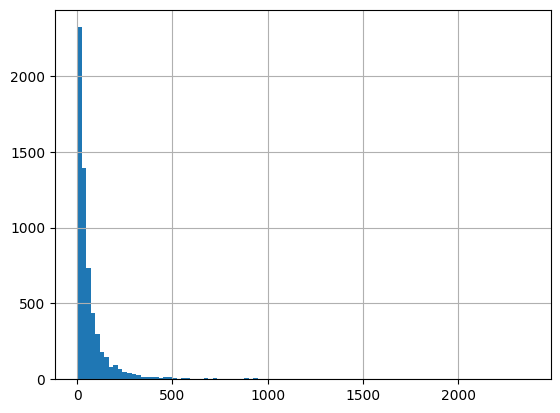

In [22]:
length = train_balanced['total_number_of_tokens']
length.hist(bins=100);


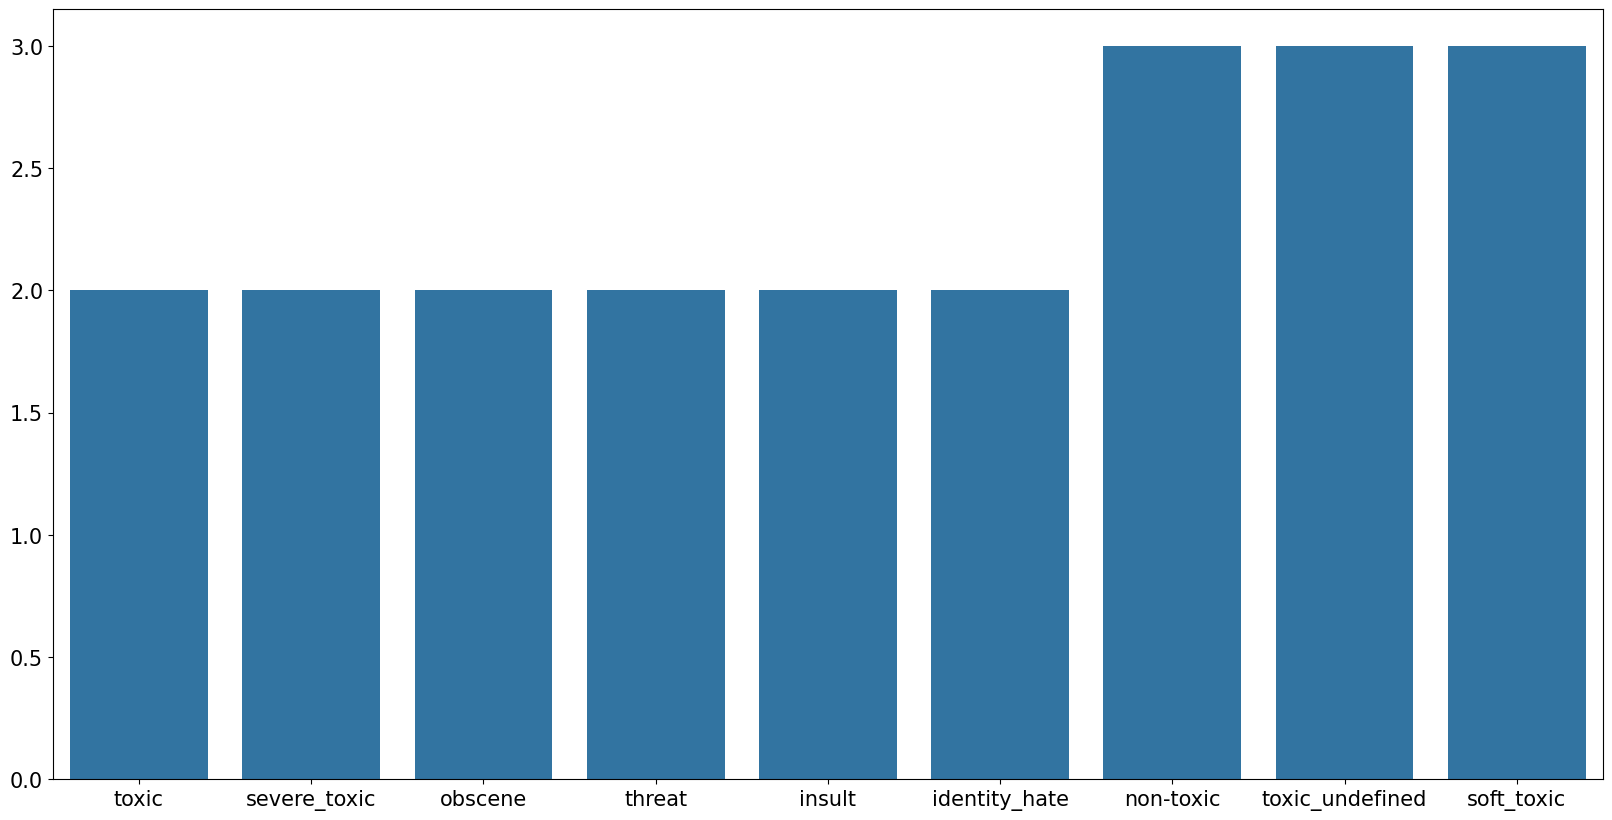

In [23]:
mc_length = []

for label in analysis_columns:
    mc_length.append(train_balanced.loc[train_balanced[label]==1,'number_of_sentences'].median())

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=analysis_columns, y=mc_length)
ax.tick_params(labelsize=15)

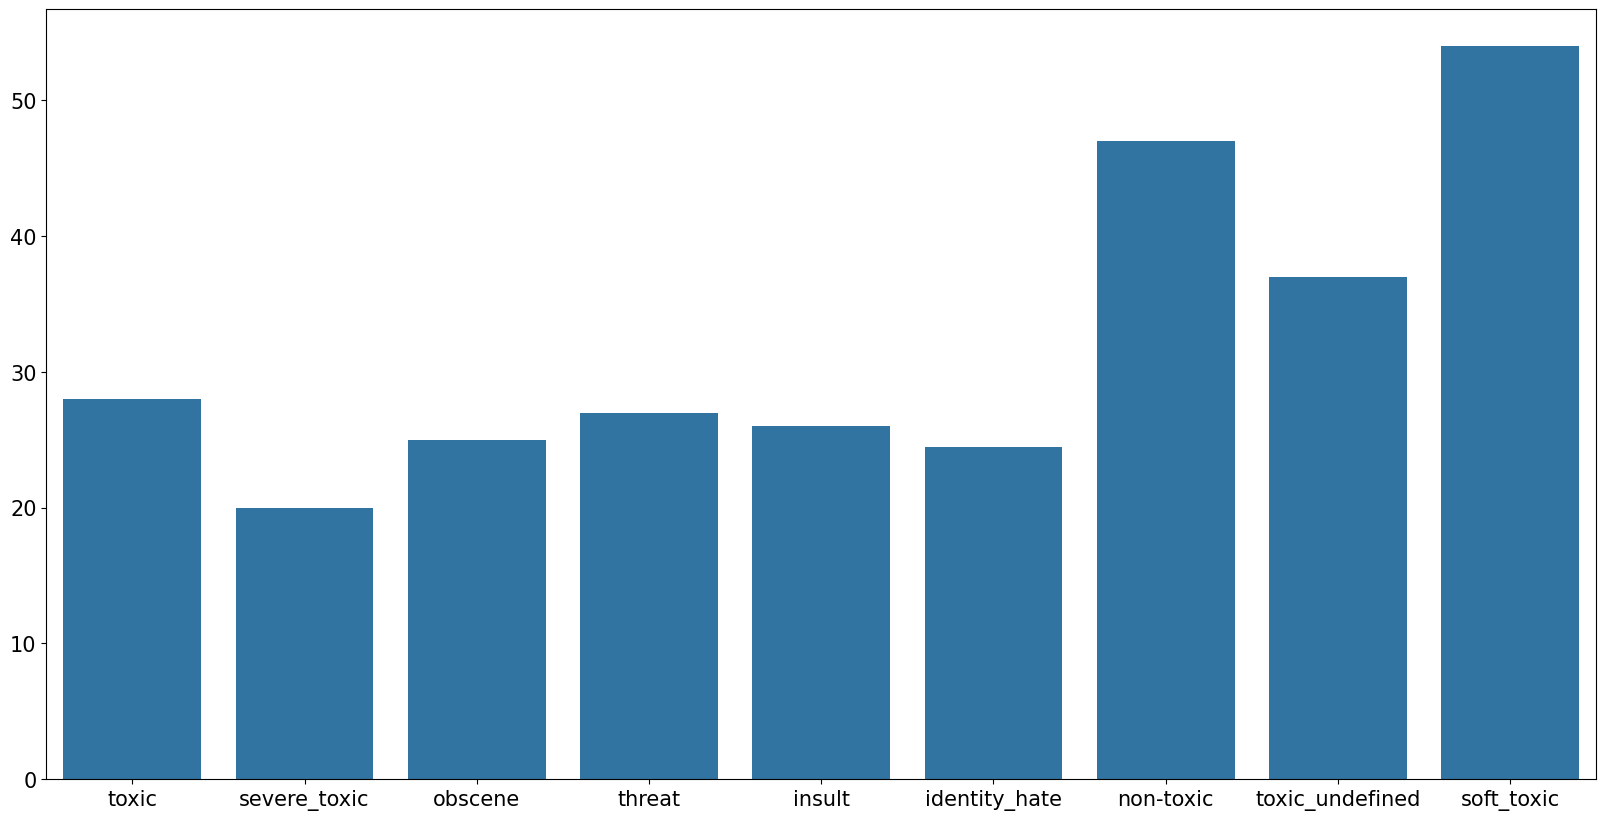

In [24]:
mc_length = []

for label in analysis_columns:
    mc_length.append(train_balanced.loc[train_balanced[label]==1,'total_number_of_tokens'].median())

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=analysis_columns, y=mc_length)
ax.tick_params(labelsize=15)

In [25]:
log_max = np.log(train_balanced['total_number_of_tokens'].max())
train_balanced['log_tokens'] = train_balanced['total_number_of_tokens']**(1/log_max)
upper = train_balanced['log_tokens'].max()
train_balanced['log_tokens_normalised'] = (train_balanced['log_tokens'])/(upper)
#helpful_log_max_root = df.Helpful_Votes**(1/log_maxlog_max

<ipython-input-26-cb7a33675be7>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-26-cb7a33675be7>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-26-cb7a33675be7>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-26-cb7a33675be7>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
<ipython-input-26-cb7a33675be7>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

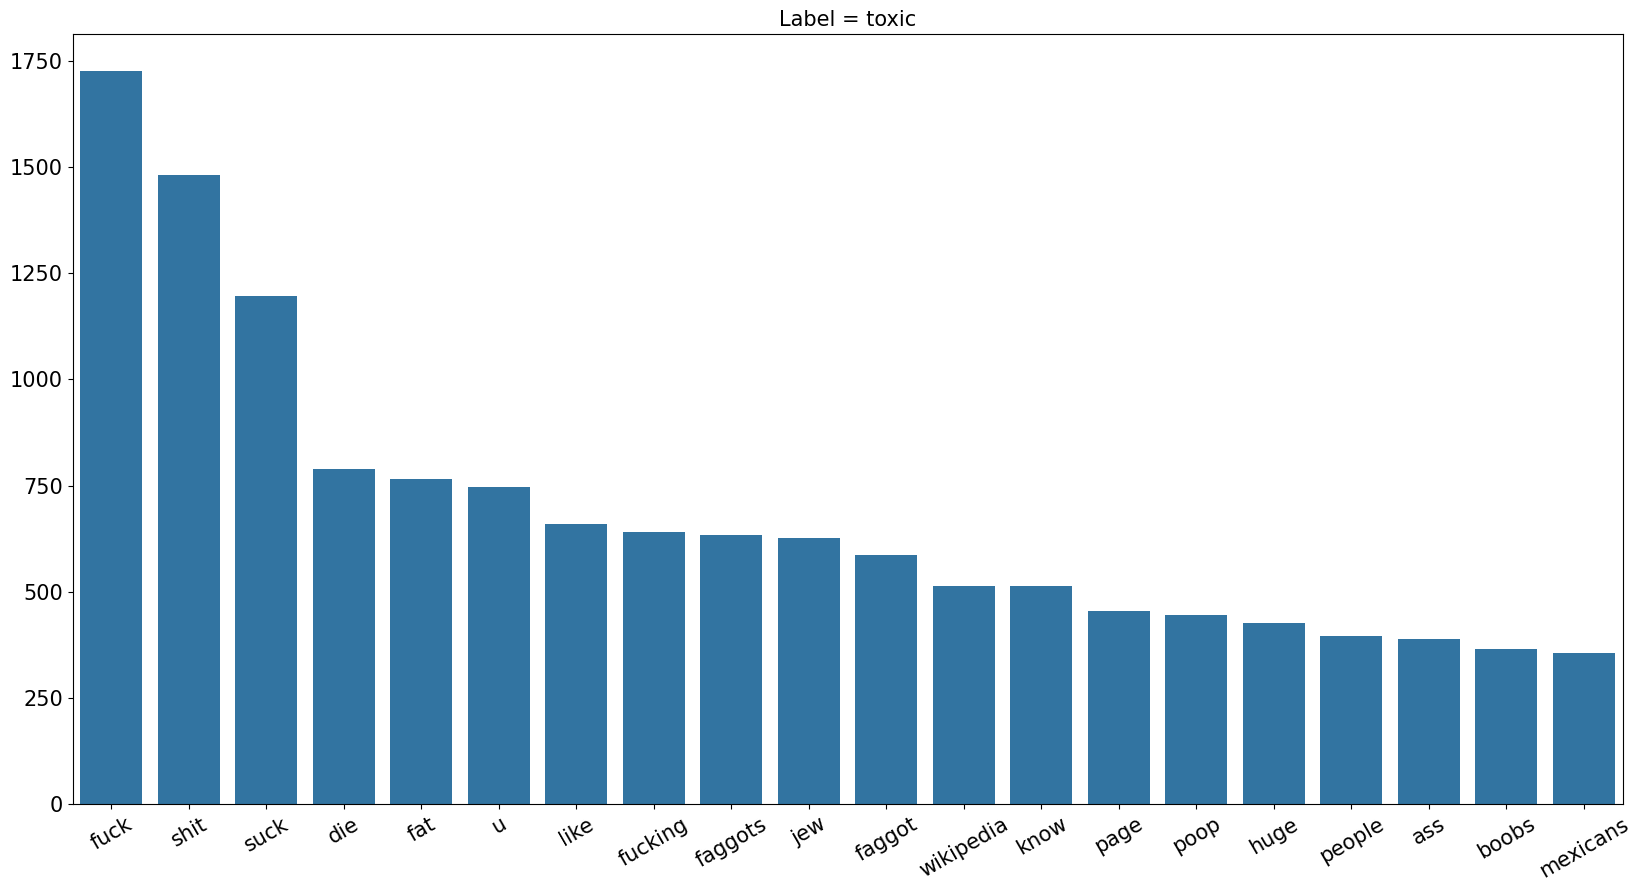

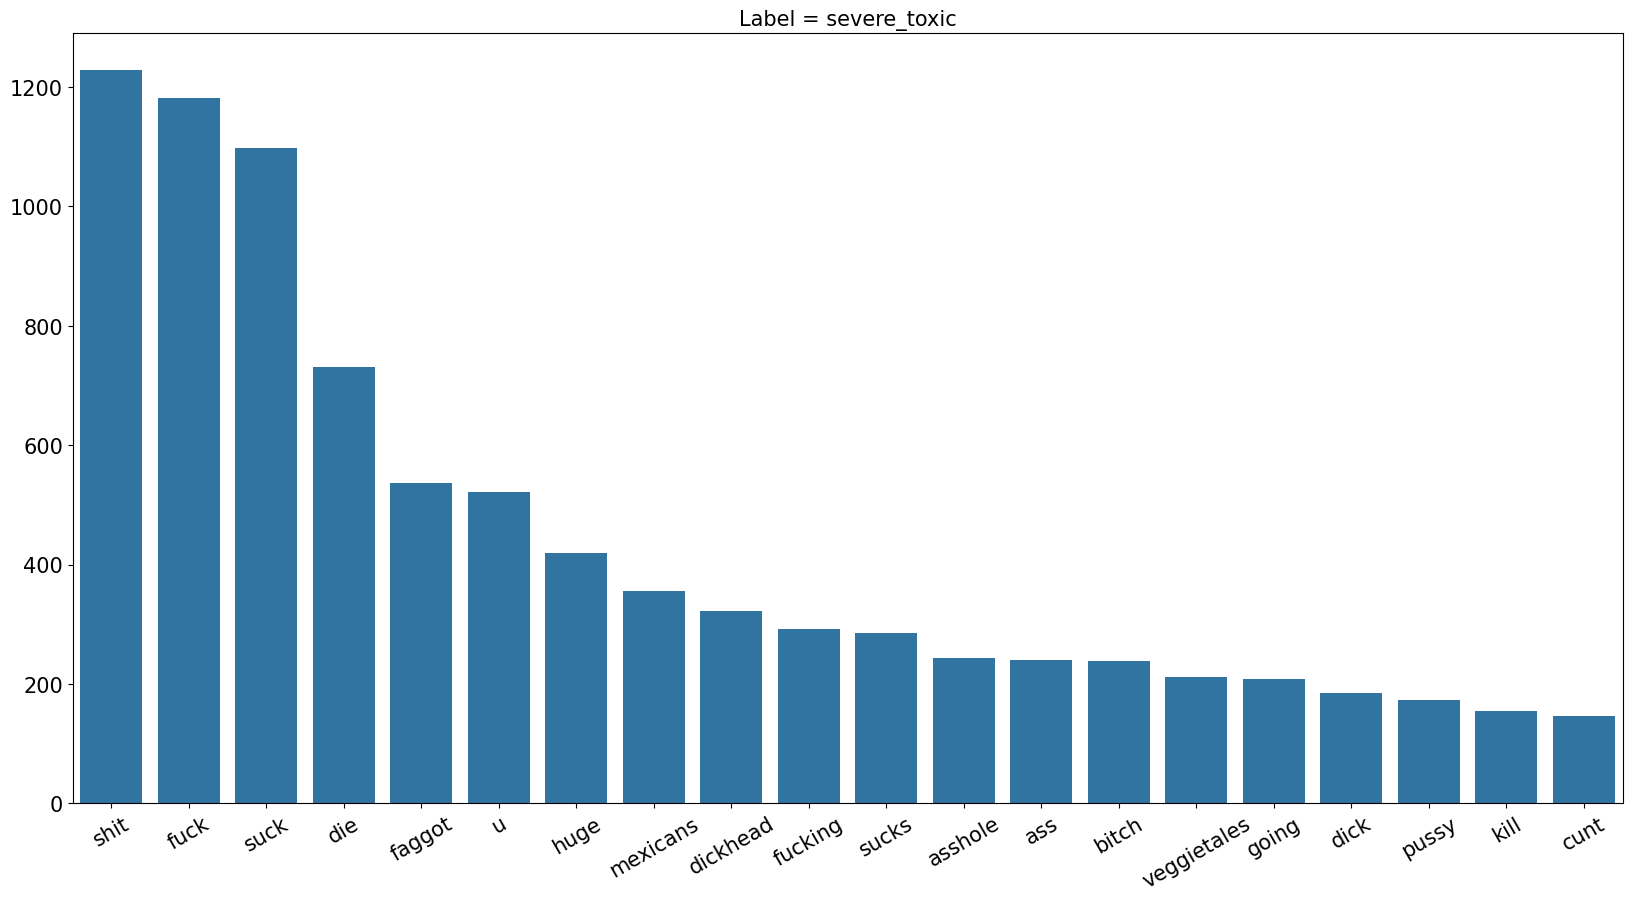

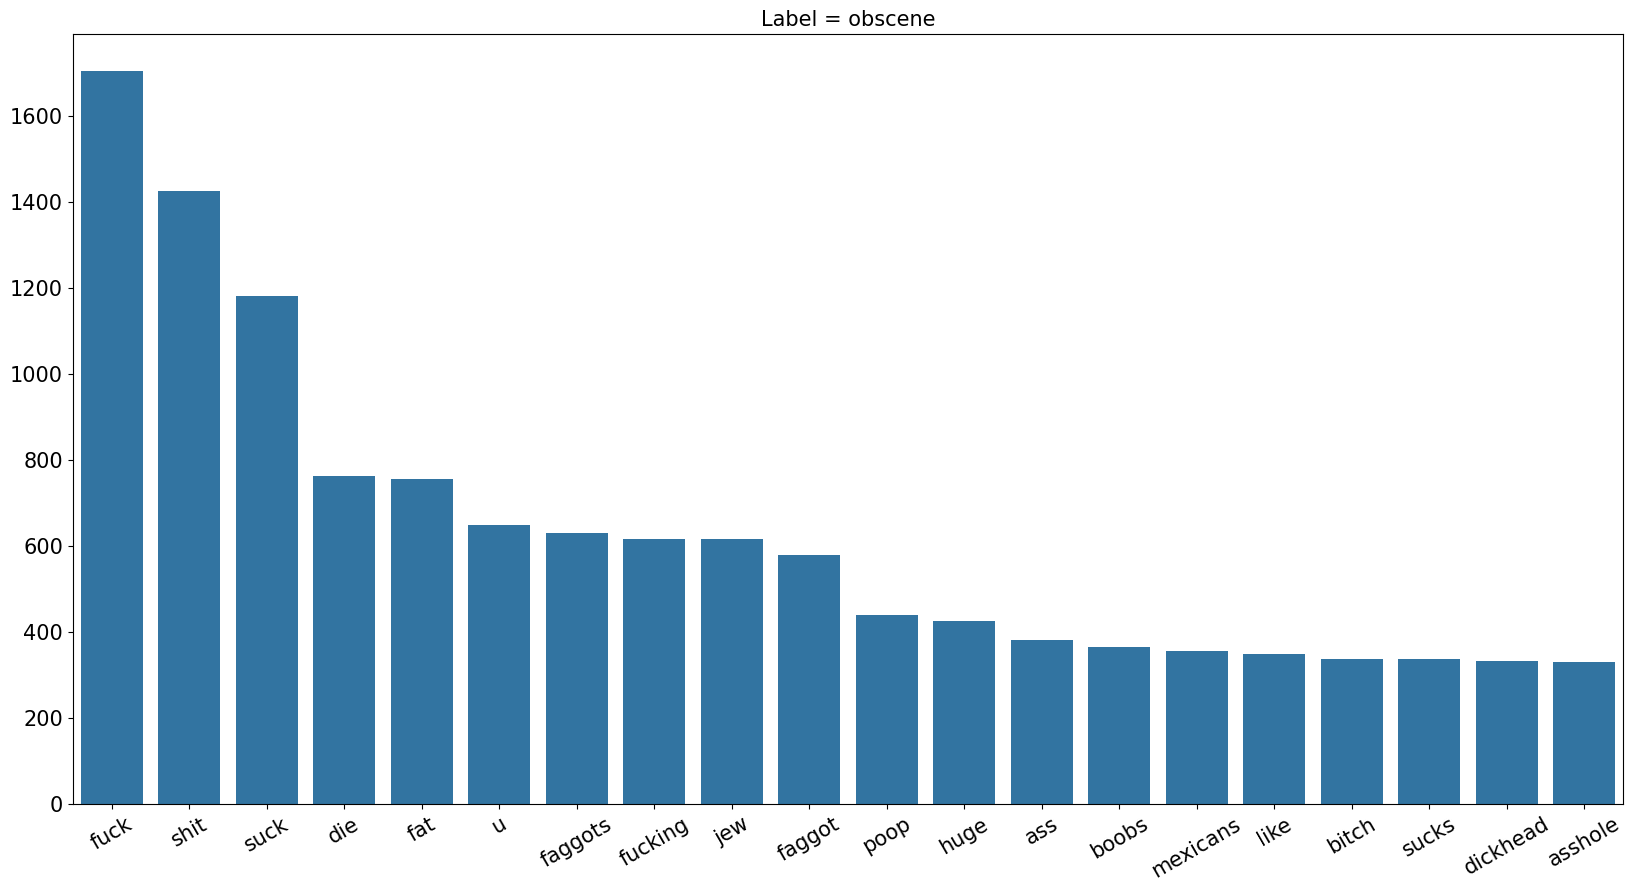

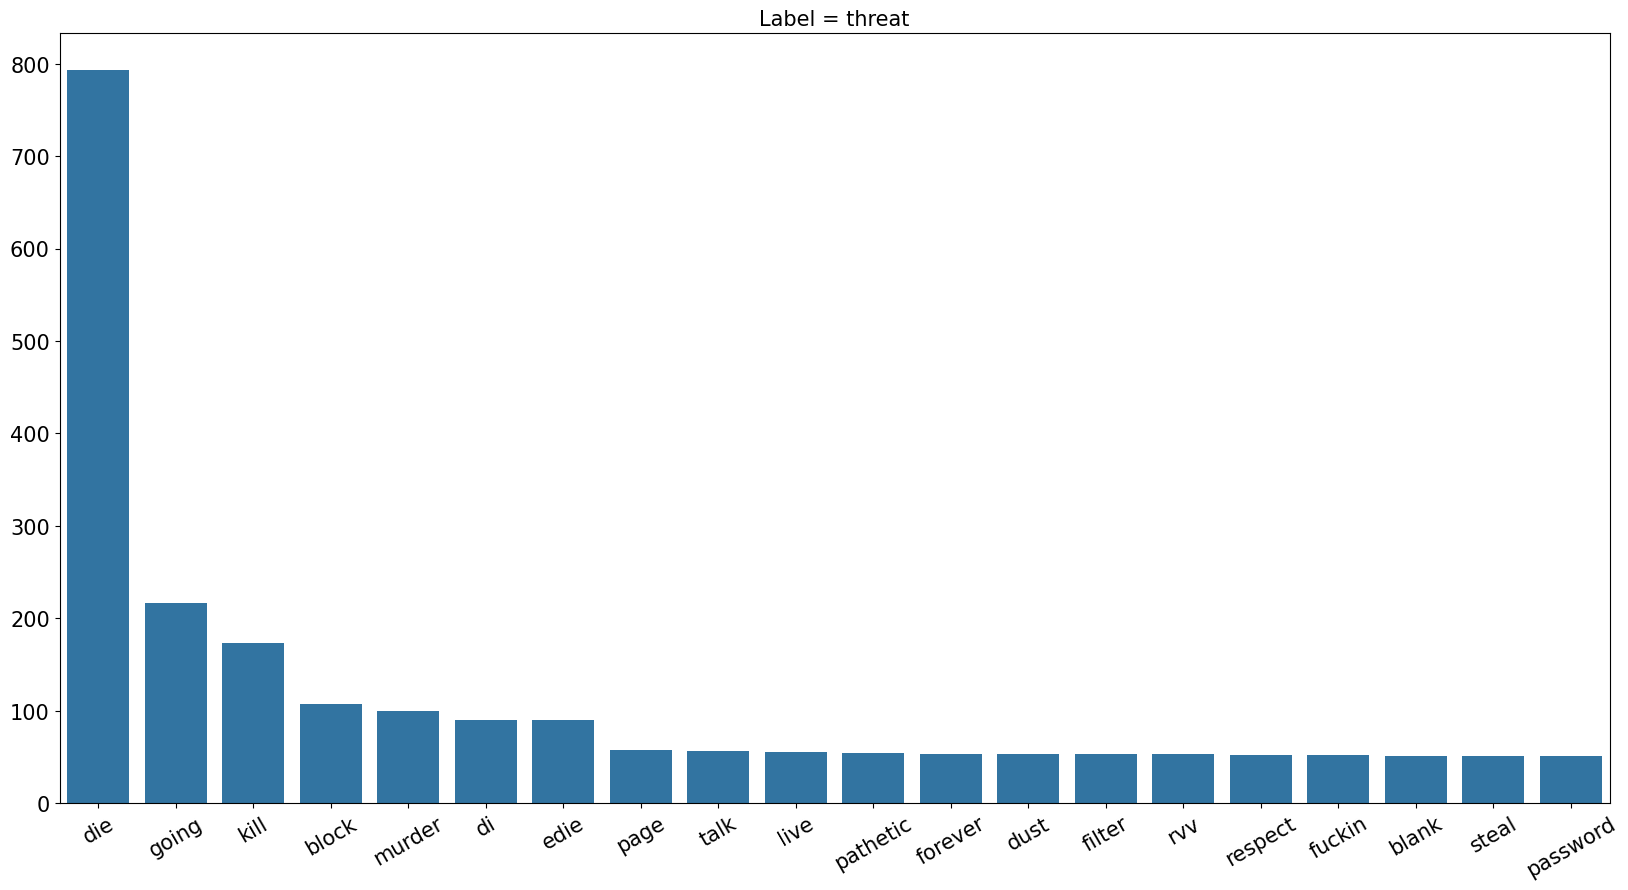

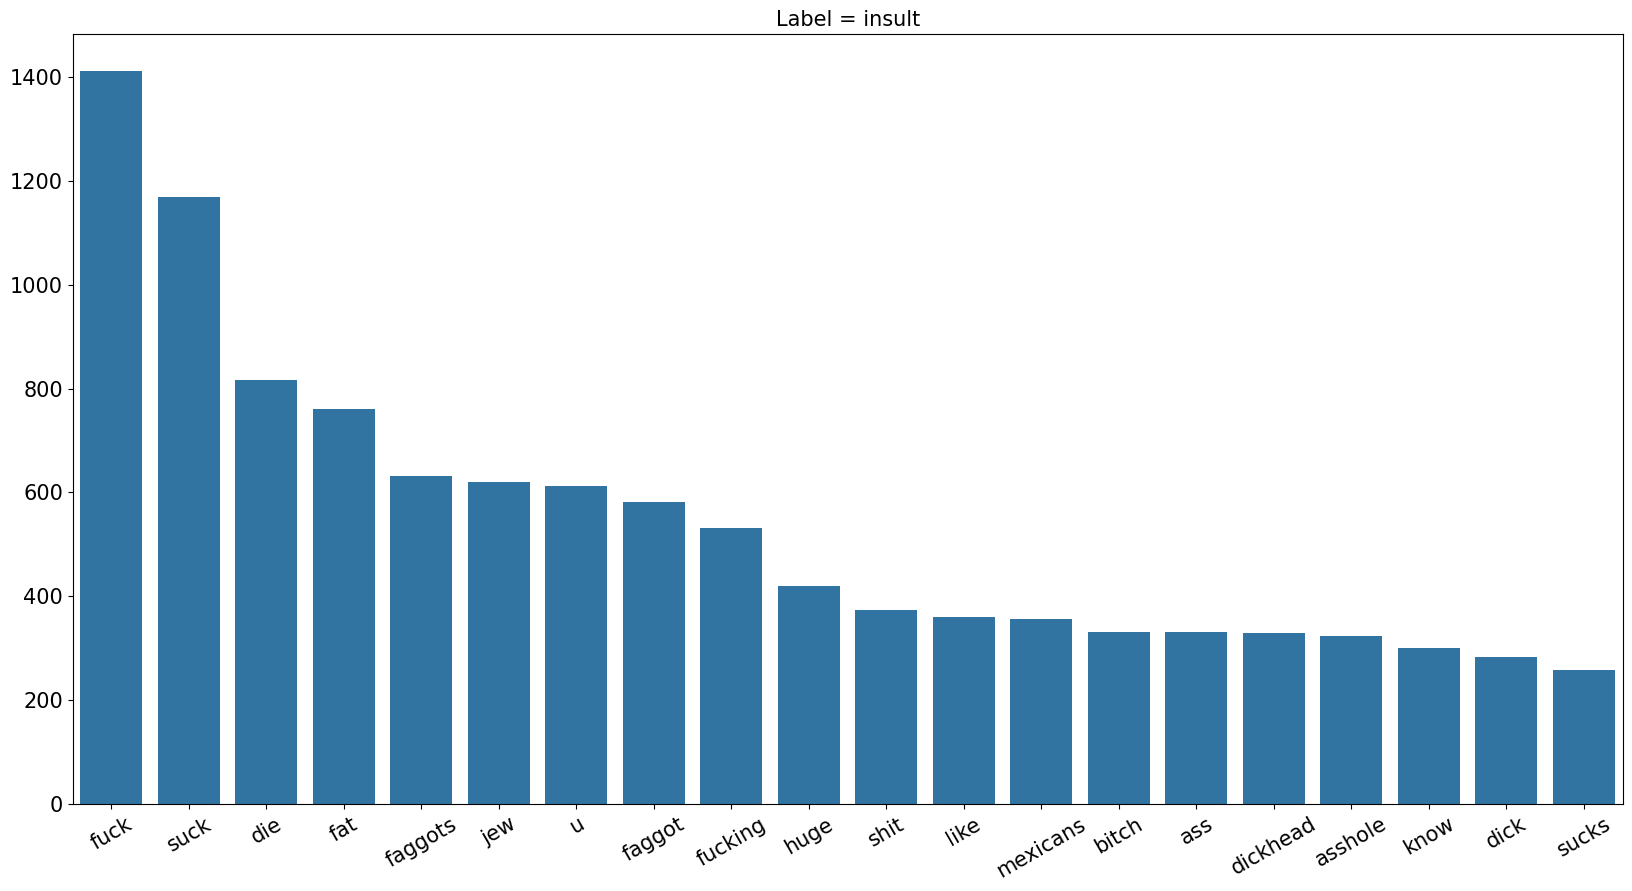

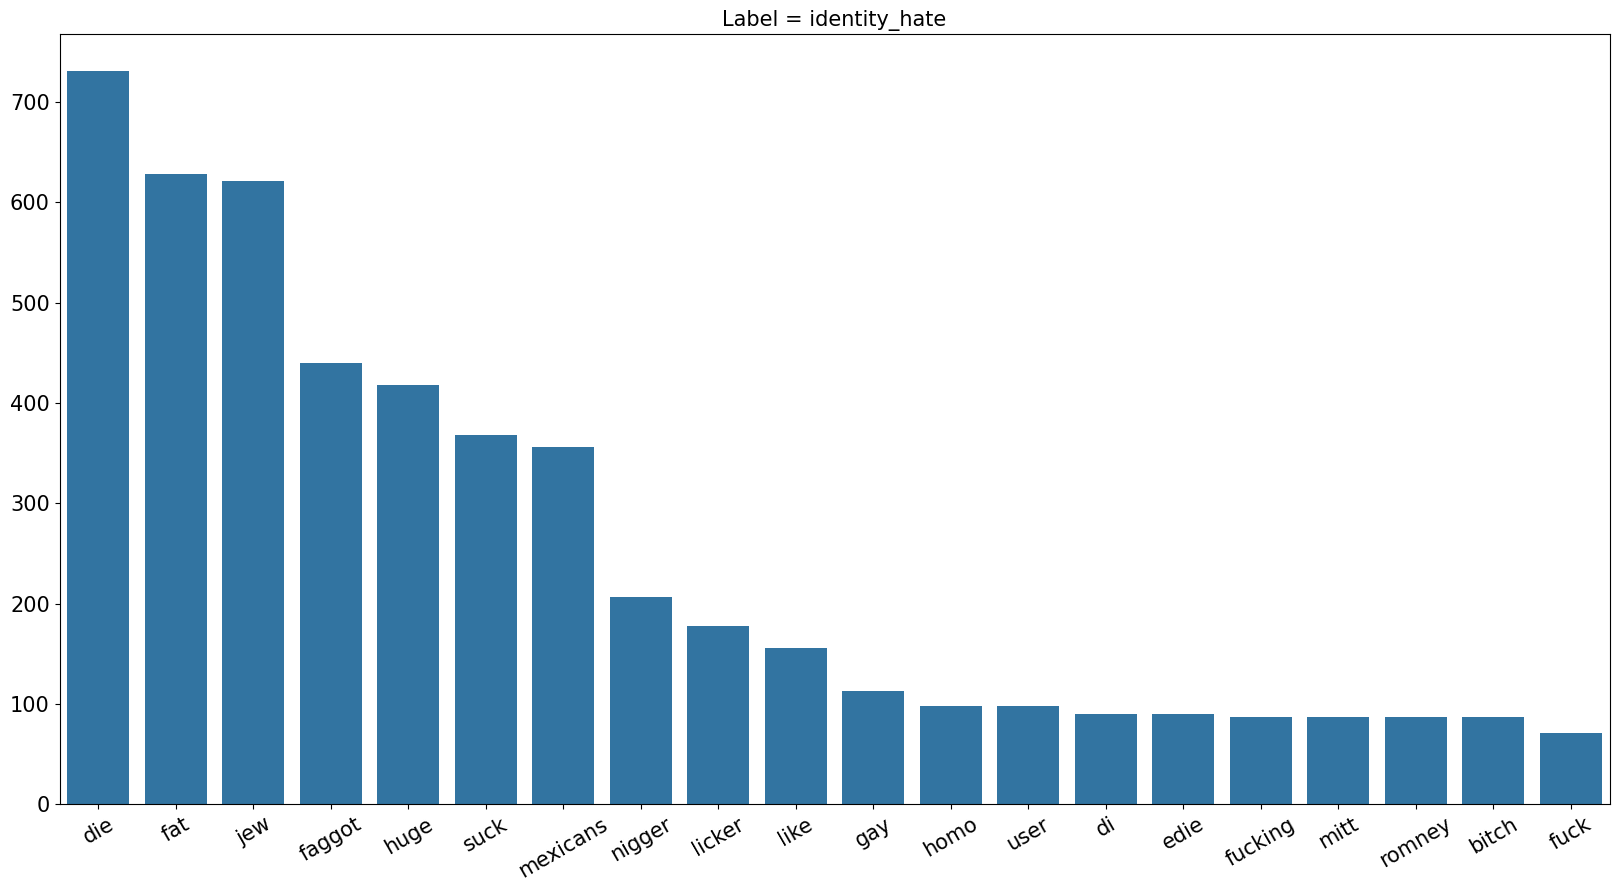

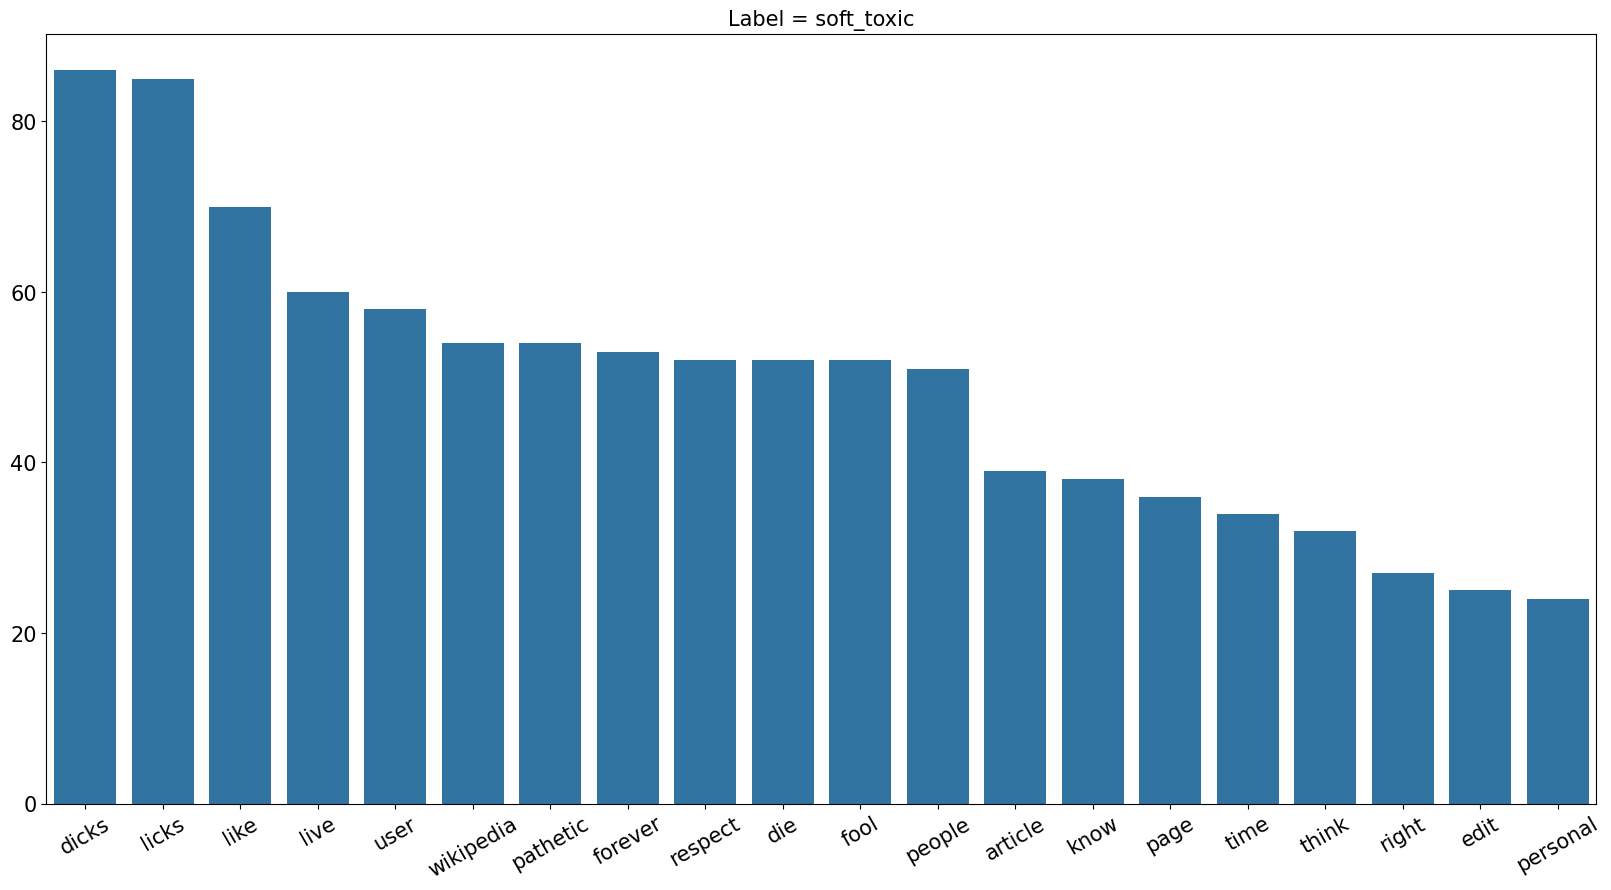

In [26]:
for label in target_columns:
    word_list = list(train_balanced.loc[train_balanced[label]==1, 'nonstop_tokens'].explode())
    most_common = collections.Counter(word_list).most_common(20)
    words = [w for w,_ in most_common]
    counts = [c for _,c in most_common]
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x=words, y=counts)
    ax.set_title(f'Label = {label}', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [27]:
val_border = int(len(train_balanced)*0.6)
validation_set = train_balanced[val_border:].copy()

In [28]:
compare_set = ['toxic', 'insult', 'obscene']

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_features=5000)
vectorizer.fit(train_balanced['comment_text'])
vectorizer

TfidfVectorizer(max_features=5000, ngram_range=(1, 5))

In [30]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 5),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [31]:
x_train = vectorizer.transform(train_balanced['comment_text'])

In [32]:
# Define target columns
target_columns = list(sample.columns.drop('id'))

# Combine target columns for a multi-label classification problem
train['labels'] = train[target_columns].values.tolist()

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train['comment_text'].values,
    train['labels'].values,
    test_size=0.2,
    random_state=42
)


In [46]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training data
#train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512, return_tensors='pt')


# Tokenize the validation data
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512, return_tensors='pt')

In [51]:
# Ensure labels are a 2D NumPy array with consistent dimensions

train_labels = np.array([np.array(label, dtype=np.float32) for label in train_labels])
val_labels = np.array([np.array(label, dtype=np.float32) for label in val_labels])

# Convert training data into PyTorch tensors
#train_encodings = {key: torch.tensor(val, dtype=torch.long) for key, val in train_encodings.items()}

train_labels = torch.tensor(train_labels, dtype=torch.float32)

# Convert validation data into PyTorch tensors
#val_encodings = {key: torch.tensor(val, dtype=torch.long) for key, val in val_encodings.items()}

val_labels = torch.tensor(val_labels, dtype=torch.float32)

# Prepare training dataset
train_dataset = torch.utils.data.TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

# Prepare validation dataset
val_dataset = torch.utils.data.TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)


In [52]:
import torch
from torch.utils.data import Dataset

class ToxicCommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Convert encodings to dataset
train_dataset = ToxicCommentDataset(train_encodings, train_labels)
val_dataset = ToxicCommentDataset(val_encodings, val_labels)


In [53]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(target_columns),
    problem_type="multi_label_classification"
)

model.gradient_checkpointing_enable()  # Enable gradient checkpointing


from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [54]:
from torch.utils.data import Subset
import numpy as np

# Reduce the training set to approximately 10,000 samples
train_subset_indices = np.random.choice(len(train_dataset), size=10000, replace=False)
train_dataset = Subset(train_dataset, train_subset_indices)

# Sample 20% of the validation set for evaluation
subset_indices = np.random.choice(len(val_dataset), size=int(0.2 * len(val_dataset)), replace=False)
val_subset = Subset(val_dataset, subset_indices)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_subset,  # Use the smaller subset
    tokenizer=tokenizer,
)


<ipython-input-54-a580b0d8abf3>:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
# Train the model
trainer.train()

<ipython-input-35-10bb392c1c4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-35-10bb392c1c4e>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)


Epoch,Training Loss,Validation Loss
1,0.066100,0.049715
2,0.035500,0.049487
3,0.025300,0.049918


<ipython-input-35-10bb392c1c4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-35-10bb392c1c4e>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
<ipython-input-35-10bb392c1c4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-35-10bb392c1c4e>:14: UserWarning: To copy construct from a tenso

TrainOutput(global_step=3750, training_loss=0.043096463362375895, metrics={'train_runtime': 4760.956, 'train_samples_per_second': 6.301, 'train_steps_per_second': 0.788, 'total_flos': 7893615144960000.0, 'train_loss': 0.043096463362375895, 'epoch': 3.0})

In [ ]:
# Evaluate the model on validation data
predictions = trainer.predict(val_dataset)
logits = predictions.predictions
labels = val_labels.numpy()  # Extract true labels


# Prepare the test data for predictions
test_encodings = tokenizer(list(test['comment_text']), truncation=True, padding=True, max_length=512)
#test_encodings = {key: torch.tensor(val) for key, val in test_encodings.items()}
test_encodings = {key: torch.tensor(val) for key, val in zip(['input_ids', 'attention_mask'], test_encodings)}


# Prepare the test dataset
test_dataset = torch.utils.data.TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask']
)

# Predict on the test dataset
predictions = trainer.predict(test_dataset)

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()

# Save the predictions into the test DataFrame
test[target_columns] = probs

# Save the submission file
test[sample.columns.to_list()].to_csv("bert_submission.csv", index=False)

<ipython-input-52-10bb392c1c4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-52-10bb392c1c4e>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)


In [43]:
# Logistic regression based on TF-IDF
lr_classifier = LogisticRegression(solver='liblinear')
average_roc = 0

for label in target_columns:
    lr_classifier.fit(x_train[:val_border], train_balanced[label][:val_border])
    predictions = lr_classifier.predict(x_train[val_border:])
    print(f'Label = {label}')
    print(classification_report(validation_set[label], predictions))
    auc = roc_auc_score(validation_set[label], predictions)
    print(f'AUC: {auc}')
    average_roc += auc

average_roc /= len(target_columns)
print(f'Average AUC: {average_roc}')

Label = toxic
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1243
           1       0.84      0.82      0.83      1202

    accuracy                           0.83      2445
   macro avg       0.83      0.83      0.83      2445
weighted avg       0.83      0.83      0.83      2445

AUC: 0.8341926100639454
Label = severe_toxic
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2322
           1       0.59      0.11      0.18       123

    accuracy                           0.95      2445
   macro avg       0.77      0.55      0.58      2445
weighted avg       0.94      0.95      0.93      2445

AUC: 0.5509075439591605
Label = obscene
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1775
           1       0.93      0.54      0.68       670

    accuracy                           0.86      2445
   macro avg       0.89      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
